In [2]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import plotly as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
direccion=r"C:/Users/Guille/Desktop/Clustering_Guille/dataset_csv/Metropolitano142.csv"
df = pd.DataFrame()
df = pd.read_csv(direccion)

df["Hora"]=pd.to_datetime(df["Hora"],  format='%Y-%m-%d %H:%M:%S',dayfirst=True)
df.rename(columns={"Hora": "Fecha"}, inplace=True)
df['Hora'] = df['Fecha'].dt.hour

# cortamos el rango que no nos sirve
df=df[df["Fecha"]>'2022-01-07 23:00:00']
extra_rows = len(df) % 24
if extra_rows != 0:
    df = df.iloc[:-extra_rows]

# hallamos los valores vacios y los llenamos con el valor promedio de su columna
nan_columns = df.columns[df.isnull().any()].tolist()
df[nan_columns] = df[nan_columns].fillna(df[nan_columns].mean())

data=df.copy()
data["Fecha"]=pd.to_datetime(data["Fecha"],dayfirst=True)
data = data.set_index('Fecha')
data.pop(data.columns.values[-1])

data # 121 usuarios, 552 horas = 23 días

,171,170,169,168,167,166,165,164,163,162,...,60,59,58,57,56,55,54,53,52,51
Fecha,,,,,,,,,,,,,,,,,,,,,
2022-01-08 00:00:00,2.656,1.936,3.420,0.332,2.402,3.626000,2.994,1.340,2.222000,4.986,...,0.924,1.568,1.882,3.208,0.112,1.920,1.596,2.594,0.922,2.852
2022-01-08 01:00:00,2.204,1.504,3.680,0.324,2.998,3.024000,4.178,1.262,2.044000,3.656,...,0.242,1.460,1.942,2.864,0.112,1.418,1.722,2.018,2.572,2.748
2022-01-08 02:00:00,2.188,1.452,2.676,0.674,2.772,2.758000,3.858,0.956,1.766000,3.268,...,0.624,0.202,1.922,2.602,0.108,1.024,1.548,1.992,2.798,2.572
2022-01-08 03:00:00,1.924,1.398,2.508,0.366,5.884,1.028000,3.418,0.194,3.506000,3.308,...,0.352,0.158,1.850,2.260,0.108,0.988,2.754,1.922,2.418,2.556
2022-01-08 04:00:00,1.796,1.412,2.280,0.320,6.868,0.520000,3.352,0.230,3.122000,4.306,...,0.234,0.086,1.832,1.922,0.106,0.474,2.776,1.898,1.626,1.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-30 19:00:00,1.306,1.208,3.300,2.590,0.662,1.797503,0.872,2.014,3.081973,1.572,...,0.070,0.030,2.640,0.746,0.300,2.172,2.618,0.960,0.244,2.678
2022-01-30 20:00:00,0.748,0.796,3.478,3.944,0.712,1.797503,0.724,1.980,3.081973,2.266,...,0.068,0.174,2.404,1.236,0.296,1.812,2.460,1.206,0.200,2.836
2022-01-30 21:00:00,1.760,0.584,3.176,3.120,0.704,1.797503,0.852,1.462,3.081973,3.260,...,0.062,0.794,2.070,0.984,0.288,2.722,2.170,2.958,0.818,2.358


### Lomb-Scargle Periodogram

In [5]:
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

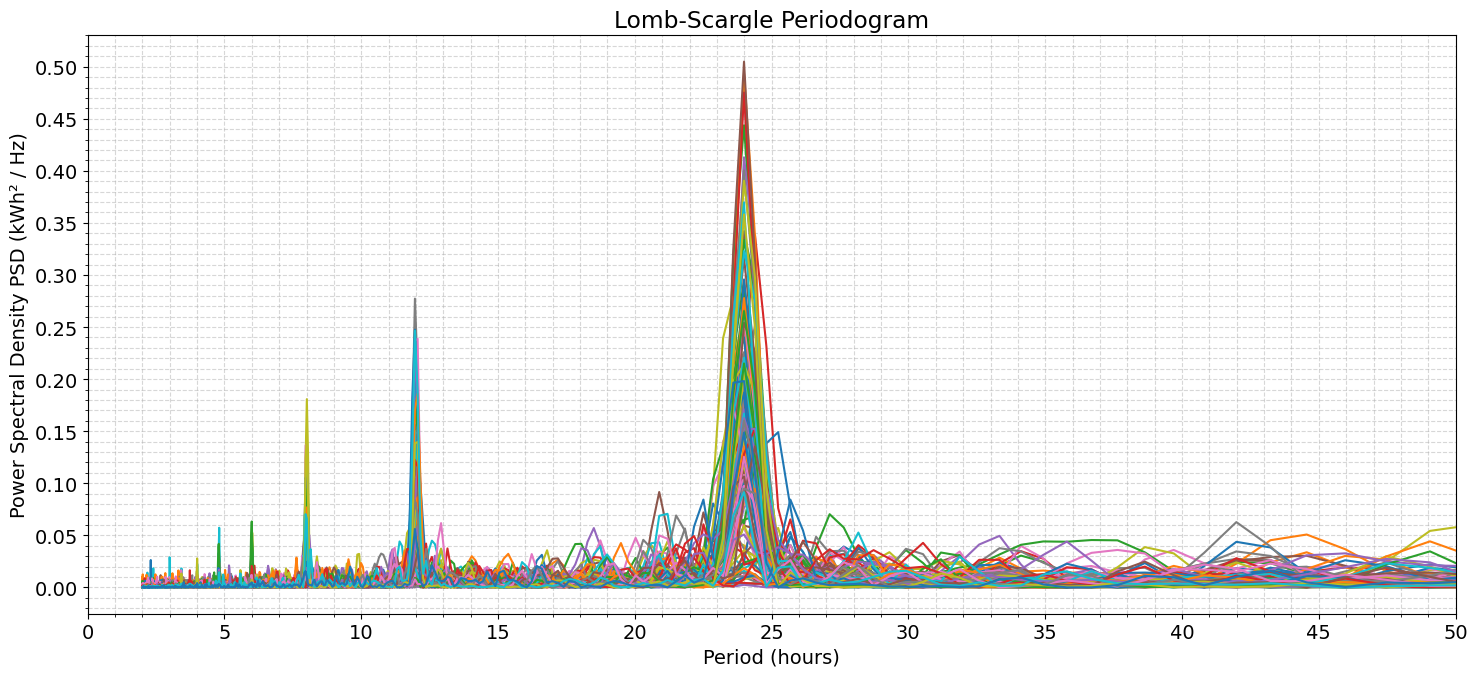

In [14]:
num_usuarios_a_mostrar = 121
usuarios_seleccionados = data.columns[:num_usuarios_a_mostrar]

# Convertimos el índice (fechas) a valores numéricos en horas
time = (data.index - data.index[0]).total_seconds() / 3600

plt.figure(figsize=(15, 7))
plt.rcParams.update({'font.size': 14})

frequencies = np.linspace(1/(1*168), 1/2, 720)  # Frecuencias en Hz
delta_f = frequencies[1] - frequencies[0]       # Resolución de frecuencia

for usuario in usuarios_seleccionados:
    
    consumo_usuario = data[usuario].dropna()
    tiempo_usuario = time[data[usuario].notna()]
    
    ls = LombScargle(tiempo_usuario, consumo_usuario)
    power_spectrum = ls.power(frequencies)
    periods = frequencies**-1

    plt.plot(periods, power_spectrum, label=f'{usuario}')

    # Personalizar el gráfico
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(True, which='both', linestyle='--', alpha=0.5)

plt.xlim(0, 50)
plt.xlabel('Period (hours)')
plt.ylabel('Power Spectral Density PSD (kWh² / Hz)')
plt.title('Lomb-Scargle Periodogram')
plt.tight_layout()
#plt.legend(loc='upper right')
plt.show()

Picos principales presentes en 24, 12, 8, 6 horas

Con PSDs en cada pico de 0.51, 0.28, 0.18, 0.61, 0.59

[{'24h': 0.1665080913909076, '12h': 0.05569644390553346, '8h': 0.08330563082872101, '6h': 0.0062706406687113815}, {'24h': 0.10559275119187046, '12h': 0.08781211556063681, '8h': 0.03295852742601244, '6h': 0.006007125092976993}, {'24h': 0.14125250297118697, '12h': 0.005927840259726669, '8h': 0.0004113259173621036, '6h': 0.004925580021839783}]


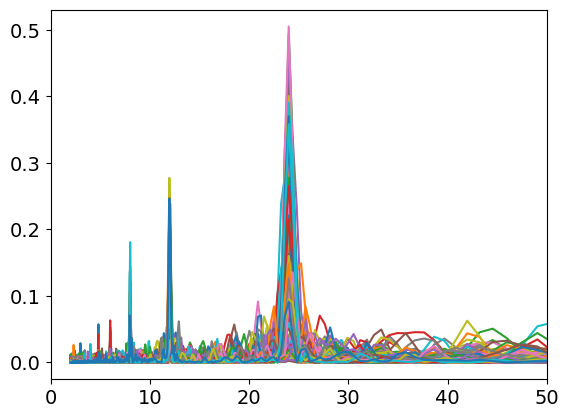

In [16]:
# Configuración
num_usuarios_a_mostrar = 121
usuarios_seleccionados = data.columns[:num_usuarios_a_mostrar]

# Convertimos el índice (fechas) a valores numéricos en horas
time = (data.index - data.index[0]).total_seconds() / 3600

# Frecuencias para el periodograma
frequencies = np.linspace(1/(1*168), 1/2, 720)  # en Hz
periods = 1 / frequencies
delta_f = frequencies[1] - frequencies[0]

# Periodos objetivo en horas
target_periods = [24, 12, 8, 6]
user_psds = []

for usuario in usuarios_seleccionados:
    
    consumo_usuario = data[usuario].dropna()
    tiempo_usuario = time[data[usuario].notna()]

    periods = frequencies**-1
    plt.plot(periods, power_spectrum, label=f'{usuario}')
    plt.xlim(0, 50)
    
    # Calcular Lomb-Scargle
    ls = LombScargle(tiempo_usuario, consumo_usuario)
    power_spectrum = ls.power(frequencies)
    
    # Extraer PSDs en periodos específicos
    psd_dict = {}
    for period in target_periods:
        idx = np.argmin(np.abs(periods - period))
        psd_dict[f'{period}h'] = power_spectrum[idx]
    
    user_psds.append(psd_dict)

# Ahora user_psds contiene la información necesaria
print(user_psds[:3])  # Muestra los primeros 3 para verificar

In [21]:
# Filtrar usuarios con NaN en los PSD
user_psds_clean = []
usuarios_clean = []

for i, psd_dict in enumerate(user_psds):
    # Verificar si alguno de los valores es NaN
    if all(not pd.isna(value) for value in psd_dict.values()):
        user_psds_clean.append(psd_dict)
        usuarios_clean.append(usuarios_seleccionados[i])
    else:
        print(f"Usuario eliminado por NaNs en PSD: {usuarios_seleccionados[i]}")

# Resultado
print(f"\nTotal usuarios válidos: {len(user_psds_clean)} de {len(user_psds)}")

user_psds = user_psds_clean


Total usuarios válidos: 120 de 120


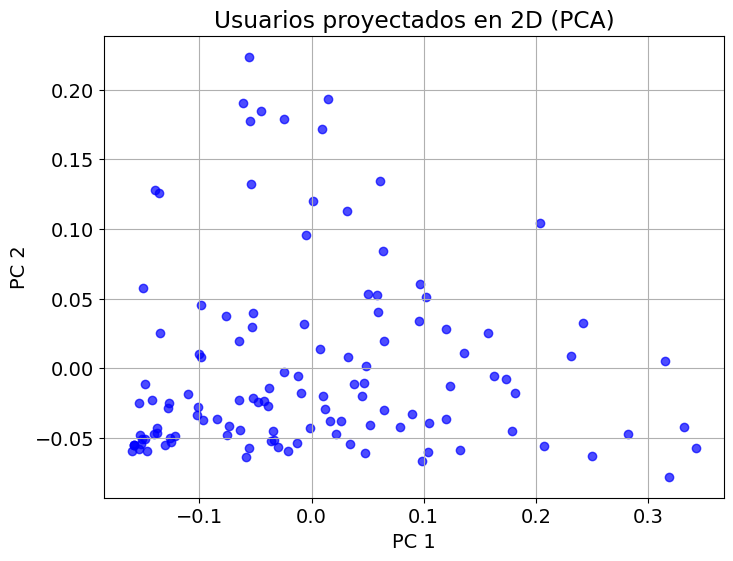

In [38]:
from sklearn.decomposition import PCA

# Simulación de entrada: lista de diccionarios con PSD por usuario (esto lo reemplazas por tus datos reales)
# user_psds = [{'24h': 0.51, '12h': 0.28, '8h': 0.18, '6h': 0.061}, ...]  # 121 usuarios

# Construcción del feature vector por usuario
def build_feature_matrix(user_psds):
    periods = ['24h', '12h', '8h', '6h']
    X = np.array([[user[period] for period in periods] for user in user_psds])
    return X

# Visualización PCA en 2D
def plot_pca_2d(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', alpha=0.7)
    plt.title(f'Usuarios proyectados en {n_components}D (PCA)')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.grid(True)
    plt.show()

# Supón que tienes la variable user_psds cargada
X = build_feature_matrix(user_psds)
plot_pca_2d(X)

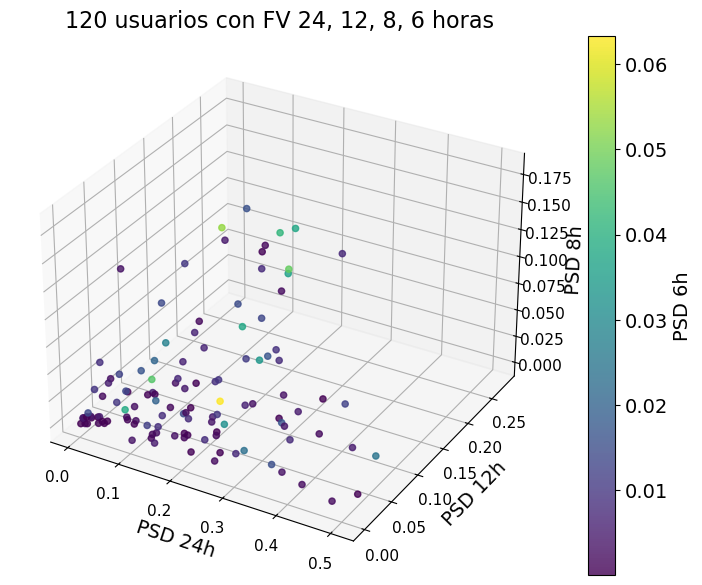

In [39]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

X = np.array([[psd['24h'], psd['12h'], psd['8h'], psd['6h']] for psd in user_psds_clean])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X[:, 3], cmap='viridis', alpha=0.8)

ax.set_xlabel('PSD 24h', fontsize=14)
ax.set_ylabel('PSD 12h', fontsize=14)
ax.set_zlabel('PSD 8h', fontsize=14)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='z', labelsize=11)

fig.colorbar(p, label='PSD 6h')
plt.title(f'{len(user_psds)} usuarios con FV 24, 12, 8, 6 horas', fontsize=16)
plt.show()

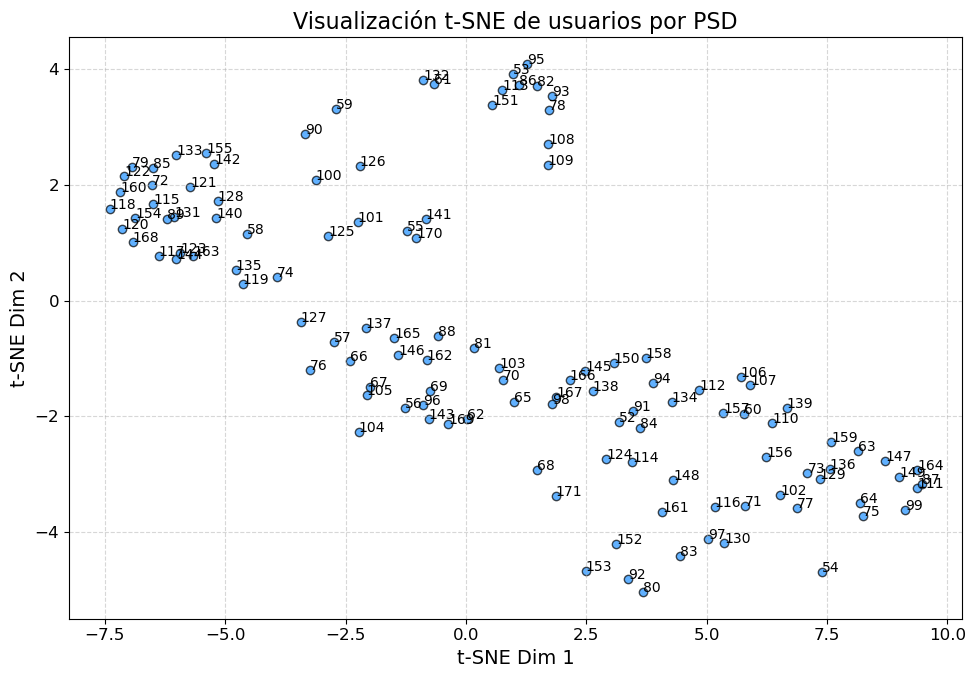

In [42]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Crear matriz de características
X = np.array([[psd['24h'], psd['12h'], psd['8h'], psd['6h']] for psd in user_psds_clean])

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
X_tsne = tsne.fit_transform(X)

# Graficar resultados
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, c='dodgerblue', edgecolor='k')
plt.title('Visualización t-SNE de usuarios por PSD', fontsize=16)
plt.xlabel('t-SNE Dim 1', fontsize=14)
plt.ylabel('t-SNE Dim 2', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

for i, name in enumerate(usuarios_clean):
    plt.text(X_tsne[i, 0], X_tsne[i, 1], name, fontsize=10)

plt.show()

In [45]:
# Data binning
# Convertir a DataFrame para manipulación más cómoda
df_psds = pd.DataFrame(user_psds_clean, index=usuarios_clean)

# Definir bins: bajo (0-33%), medio (33-66%), alto (66-100%)
bins = 3
labels = ['Bajo', 'Medio', 'Alto']
binned_df = df_psds.copy()

# Aplicar binning a cada columna
for col in df_psds.columns:
    binned_df[col] = pd.qcut(df_psds[col], q=bins, labels=labels)

binned_df

,24h,12h,8h,6h
171,Medio,Medio,Alto,Medio
170,Medio,Alto,Alto,Medio
169,Medio,Bajo,Bajo,Medio
168,Bajo,Bajo,Bajo,Bajo
167,Medio,Medio,Medio,Bajo
...,...,...,...,...
56,Medio,Bajo,Medio,Alto
55,Bajo,Alto,Medio,Medio
54,Alto,Alto,Alto,Medio
53,Bajo,Alto,Alto,Bajo


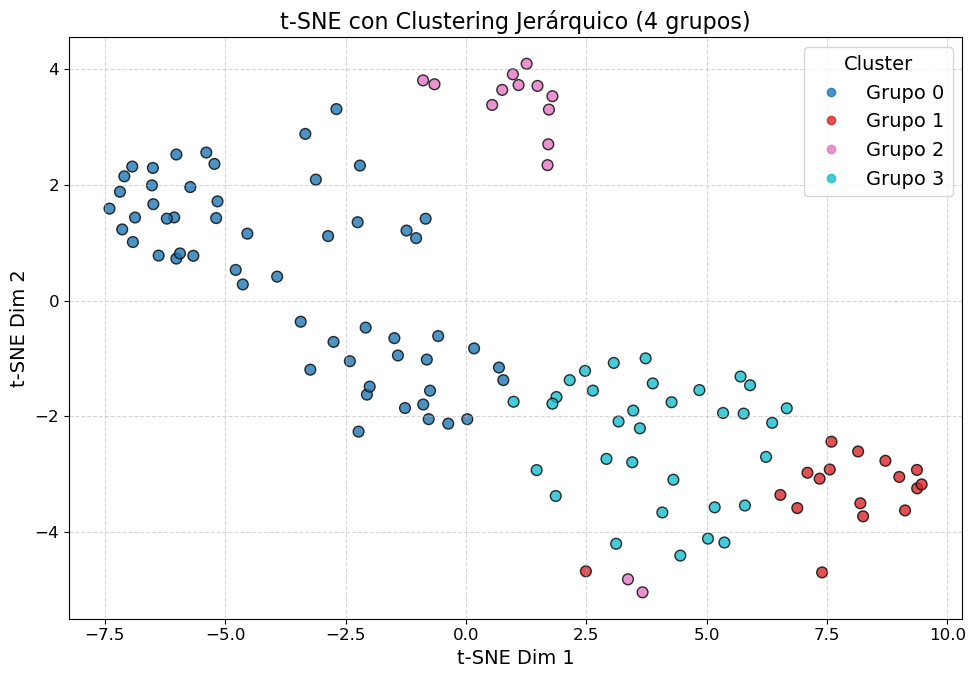

In [46]:
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt

# Suponemos que tienes la matriz de características X
X = np.array([[psd['24h'], psd['12h'], psd['8h'], psd['6h']] for psd in user_psds_clean])

# Paso 1: t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Paso 2: Clustering jerárquico
n_clusters = 4  # Puedes ajustar según necesidad
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = clustering.fit_predict(X)

# Paso 3: Visualización
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=60, edgecolor='k', alpha=0.8)
plt.title(f't-SNE con Clustering Jerárquico ({n_clusters} grupos)', fontsize=16)
plt.xlabel('t-SNE Dim 1', fontsize=14)
plt.ylabel('t-SNE Dim 2', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Opcional: leyenda de grupos
legend_labels = [f'Grupo {i}' for i in range(n_clusters)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Cluster')
plt.tight_layout()
plt.show()


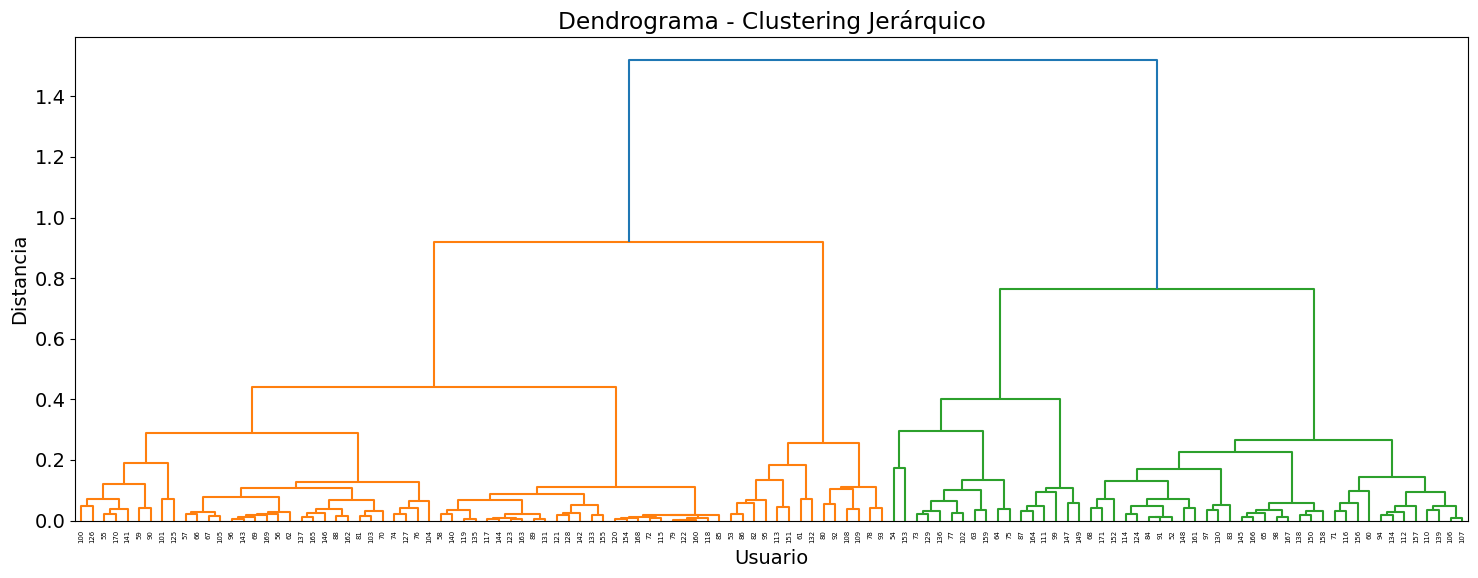

In [47]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np

# Usamos la misma matriz de características X
X = np.array([[psd['24h'], psd['12h'], psd['8h'], psd['6h']] for psd in user_psds_clean])

# Paso 1: Calcular linkage (puede usar 'ward', 'average', etc.)
linked = linkage(X, method='ward')

# Paso 2: Graficar dendrograma
plt.figure(figsize=(15, 6))
dendrogram(linked,
           orientation='top',
           labels=usuarios_clean,
           distance_sort='descending',
           show_leaf_counts=False)
plt.title('Dendrograma - Clustering Jerárquico')
plt.xlabel('Usuario')
plt.ylabel('Distancia')
plt.tight_layout()
plt.show()


# Metricas

In [48]:
# Métrica	Bueno si...	Rango típico
# Silhouette	Alto	-1 a 1 (ideal > 0.5)
# Calinski-Harabasz	Alto	No acotado
# Davies-Bouldin	Bajo	0 a ∞ (ideal < 1)
# Dunn Index	Alto	0 a ∞ (ideal > 1)

from sklearn.metrics import silhouette_score

score = silhouette_score(X, labels)
print(f'Silhouette Score: {score:.3f}')

from sklearn.metrics import calinski_harabasz_score

score = calinski_harabasz_score(X, labels)
print(f'Calinski-Harabasz Score: {score:.3f}')

from sklearn.metrics import davies_bouldin_score

score = davies_bouldin_score(X, labels)
print(f'Davies-Bouldin Score: {score:.3f}')

from scipy.spatial.distance import cdist
import numpy as np

def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    # Separar por clusters
    clusters = [X[labels == label] for label in unique_labels]

    # Intra-cluster distances (max dist dentro de cada cluster)
    intra_dists = [np.max(cdist(cluster, cluster)) for cluster in clusters]

    # Inter-cluster distances (min dist entre centros de masa de clusters)
    inter_dists = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            inter_dists.append(np.min(cdist(clusters[i], clusters[j])))

    return np.min(inter_dists) / np.max(intra_dists)

# Usar la función
dunn = dunn_index(X, labels)
print(f'Dunn Index: {dunn:.3f}')


Silhouette Score: 0.426
Calinski-Harabasz Score: 122.288
Davies-Bouldin Score: 0.804
Dunn Index: 0.075
